# NFL Draft Analysis From 1990 to 2023, for now...
- https://www.kaggle.com/datasets/dubradave/nfl-draft-history-1990-present/data

# Equations

In [176]:
from sklearn.metrics import confusion_matrix

def accuracy(x_predict, x_true):
    sum = 0

    for i in range(len(x_predict)):
        if x_predict[i] == x_true[i]:
            sum += 1
    return sum/len(x_predict)

def precision(x_predict, x_true, trueVal):
    sum = 0
    total = 0

    for i in range(len(x_predict)):
        if x_predict[i] == trueVal:
            total += 1
        if (x_predict[i] == x_true[i] and x_predict[i] == trueVal):
            sum += 1
       
    return sum/total

def recall(x_predict, x_true, trueVal):
    sum = 0
    total = 0

    for i in range(len(x_predict)):
        if (x_true[i] == trueVal and x_predict[i] != trueVal):
            total += 1
        if (x_predict[i] == x_true[i] and x_predict[i] == trueVal):
            sum += 1
    
    return sum/(sum + total)

def f1score(x_predict, x_true, trueVal):
    p = precision(x_predict, x_true, trueVal)
    r = recall(x_predict, x_true, trueVal)

    return (2 * p * r) / (p + r)

def mae(actual, calculated):
    sum = 0

    for i in range(len(actual)):
        sum += abs(calculated[i] - actual[i])

    return sum/len(actual)

def mse(actual, calculated):
    sum = 0

    for i in range(len(actual)):
        sum += pow((calculated[i] - actual[i]), 2)

    return sum/len(actual)

def sse(actual, calculated):
    sum = 0

    for i in range(len(actual)):
        sum += pow((calculated[i] - actual[i]), 2)

    return sum

def rmse(actual, calculated):
    sum = 0

    for i in range(len(actual)):
        sum += pow((calculated[i] - actual[i]), 2)

    return np.sqrt(sum/len(actual))

def rmsle(actual, calculated):
    sum = 0

    for i in range(len(actual)):
        sum += np.log(((1 + calculated[i]) / (1 + actual[i])))

    sum = sum / len(actual)
    return np.sqrt(pow(sum/len(actual), 2))

# Step One
- First part here will be loading in the dataset into a dataframe which I will be calling data for simplicity sake.
- Will do a little analysis of the data and cleaning it by checking for null values and for columns that there will be too many null values to work with.
- If necessary some of the columns may be dropped depending on the value of the variable and some sorting may need to happen to separate out offensive and defensive players.

In [177]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

data = pd.read_csv('NFLDraftHistory.csv')
data.head()

,season,round,pick,team,gsis_id,pfr_player_id,cfb_player_id,pfr_player_name,hof,position,...,pass_ints,rush_atts,rush_yards,rush_tds,receptions,rec_yards,rec_tds,def_solo_tackles,def_ints,def_sacks
0,1990,1,1,IND,NaN,GeorJe00,jeff-george-1,Jeff George,False,QB,...,113.0,168.0,307.0,2.0,0.0,0.0,0.0,NaN,NaN,NaN
1,1990,1,2,NYJ,NaN,ThomBl00,blair-thomas-1,Blair Thomas,False,RB,...,0.0,533.0,2236.0,7.0,71.0,513.0,2.0,NaN,NaN,NaN
2,1990,1,3,SEA,NaN,KennCo00,NaN,Cortez Kennedy,True,DT,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,58.0
3,1990,1,4,TAM,NaN,McCaKe21,keith-mccants-1,Keith McCants,False,DE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,13.5
4,1990,1,5,SDG,NaN,SeauJu00,junior-seau-1,Junior Seau,True,LB,...,0.0,0.0,0.0,0.0,2.0,8.0,0.0,NaN,18.0,56.5


In [178]:
# Get information on the data types and see how many of them are not null
# Will need to set it as a scrolable area to see them all
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8555 entries, 0 to 8554
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   season            8555 non-null   int64  
 1   round             8555 non-null   int64  
 2   pick              8555 non-null   int64  
 3   team              8555 non-null   object 
 4   gsis_id           2243 non-null   object 
 5   pfr_player_id     7761 non-null   object 
 6   cfb_player_id     6223 non-null   object 
 7   pfr_player_name   8555 non-null   object 
 8   hof               8555 non-null   bool   
 9   position          8555 non-null   object 
 10  category          8555 non-null   object 
 11  side              8554 non-null   object 
 12  college           8538 non-null   object 
 13  age               7756 non-null   float64
 14  to                7465 non-null   float64
 15  allpro            8555 non-null   int64  
 16  probowls          8555 non-null   int64  


In [179]:
# Get the analysis on each of the columns in the dataset and see whihc ones have good values to use later for analysis
data.describe()

,season,round,pick,age,to,allpro,probowls,seasons_started,w_av,car_av,...,pass_ints,rush_atts,rush_yards,rush_tds,receptions,rec_yards,rec_tds,def_solo_tackles,def_ints,def_sacks
count,8555.000000,8555.000000,8555.000000,7756.000000,7465.000000,8555.000000,8555.000000,8555.000000,7465.000000,0.0,...,7464.000000,7465.000000,7465.000000,7465.000000,7465.000000,7465.000000,7465.000000,4527.00000,1784.000000,2356.000000
mean,2005.734191,4.474226,131.334307,22.524755,2010.962626,0.077966,0.301578,1.957686,17.717616,NaN,...,1.538719,47.568386,197.805626,1.411922,33.487609,386.253717,2.326591,104.58140,6.574552,12.368209
std,9.698250,2.350040,77.188144,0.890109,9.102346,0.462404,1.153008,3.031799,22.124722,NaN,...,12.867817,236.563697,999.092206,7.393712,108.201927,1359.035777,8.923906,158.68361,8.484491,19.307824
min,1990.000000,1.000000,1.000000,20.000000,1990.000000,0.000000,0.000000,0.000000,-4.000000,NaN,...,0.000000,0.000000,-36.000000,0.000000,0.000000,-16.000000,0.000000,1.00000,1.000000,0.500000
25%,1997.000000,3.000000,65.000000,22.000000,2004.000000,0.000000,0.000000,0.000000,2.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.00000,1.000000,2.000000
50%,2006.000000,4.000000,130.000000,23.000000,2012.000000,0.000000,0.000000,0.000000,9.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.00000,3.000000,5.000000
75%,2014.000000,6.000000,195.000000,23.000000,2020.000000,0.000000,0.000000,3.000000,26.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,2.000000,16.000000,0.000000,142.00000,8.000000,14.000000
max,2022.000000,12.000000,336.000000,29.000000,2022.000000,7.000000,15.000000,21.000000,184.000000,NaN,...,336.000000,4409.000000,18355.000000,164.000000,1432.000000,17492.000000,156.000000,1568.00000,65.000000,159.500000


In [180]:
# Too many null values, mixed with not needing the id of the player in different publication data sets
data.drop(columns=['gsis_id', 'pfr_player_id', 'cfb_player_id', 'car_av', 'dr_av'], axis=1, inplace=True)

# check for the total nulls in the rest of the dataset, most of these are because of the side of the ball you play on and position I assume
data.isna().sum()

season                 0
round                  0
pick                   0
team                   0
pfr_player_name        0
hof                    0
position               0
category               0
side                   1
college               17
age                  799
to                  1090
allpro                 0
probowls               0
seasons_started        0
w_av                1090
games               1090
pass_completions    1090
pass_attempts       1090
pass_yards          1090
pass_tds            1090
pass_ints           1091
rush_atts           1090
rush_yards          1090
rush_tds            1090
receptions          1090
rec_yards           1090
rec_tds             1090
def_solo_tackles    4028
def_ints            6771
def_sacks           6199
dtype: int64

# Step Two
- Now that most of the null values have been cleared out I am going to try and separate out the data into position groups so that I can begin to understand how that affects it.
- This thought is from some of the columns only tracking defensive data which offensive players don't need and vice versa.

In [181]:
# Getting all the different positions in the dataset so that I can seperate players out into positions
data['category'].unique()

array(['QB', 'RB', 'DL', 'LB', 'DB', 'OL', 'TE', 'WR', 'P', 'K', 'KR',
       'LS'], dtype=object)

In [182]:
# Getting the quarterback category, the most important so started here

QB = data.where(data['category'] == 'QB')

QB.drop(columns=['def_sacks', 'def_ints', 'def_solo_tackles'], axis=1, inplace=True)
QB.dropna(axis=0, how='all', inplace=True)
QB.isna().sum()

display(QB)

# Justin = QB.where(QB['pfr_player_name'] == 'Justin Herbert')
# Justin.dropna()

,season,round,pick,team,pfr_player_name,hof,position,category,side,college,...,pass_attempts,pass_yards,pass_tds,pass_ints,rush_atts,rush_yards,rush_tds,receptions,rec_yards,rec_tds
0,1990.0,1.0,1.0,IND,Jeff George,False,QB,QB,O,Illinois,...,3967.0,27602.0,154.0,113.0,168.0,307.0,2.0,0.0,0.0,0.0
6,1990.0,1.0,7.0,DET,Andre Ware,False,QB,QB,O,Houston,...,161.0,1112.0,5.0,8.0,38.0,217.0,0.0,0.0,0.0,0.0
58,1990.0,3.0,59.0,NWE,Tom Hodson,False,QB,QB,O,LSU,...,320.0,1823.0,7.0,11.0,21.0,90.0,0.0,1.0,-6.0,0.0
62,1990.0,3.0,63.0,CHI,Peter Tom Willis,False,QB,QB,O,Florida St.,...,183.0,1261.0,6.0,15.0,5.0,14.0,0.0,0.0,0.0,0.0
69,1990.0,3.0,70.0,PIT,Neil O'Donnell,False,QB,QB,O,Maryland,...,3229.0,21690.0,120.0,68.0,215.0,446.0,4.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8429,2022.0,4.0,137.0,NWE,Bailey Zappe,False,QB,QB,O,Western Kentucky,...,92.0,781.0,5.0,3.0,10.0,0.0,0.0,1.0,-6.0,0.0
8436,2022.0,5.0,144.0,WAS,Sam Howell,False,QB,QB,O,North Carolina,...,19.0,169.0,1.0,1.0,5.0,35.0,1.0,0.0,0.0,0.0
8533,2022.0,7.0,241.0,PIT,Chris Oladokun,False,QB,QB,O,South Dakota St.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8539,2022.0,7.0,247.0,MIA,Skylar Thompson,False,QB,QB,O,Kansas St.,...,105.0,534.0,1.0,3.0,14.0,21.0,0.0,0.0,0.0,0.0


In [183]:
RB = data.where(data['category'] == 'RB')

RB.drop(columns=['def_sacks', 'def_ints', 'def_solo_tackles'], axis=1, inplace=True)
RB.dropna(axis=0, how='all', inplace=True)
RB.isna().sum()

display(RB)

,season,round,pick,team,pfr_player_name,hof,position,category,side,college,...,pass_attempts,pass_yards,pass_tds,pass_ints,rush_atts,rush_yards,rush_tds,receptions,rec_yards,rec_tds
1,1990.0,1.0,2.0,NYJ,Blair Thomas,False,RB,RB,O,Penn St.,...,1.0,16.0,1.0,0.0,533.0,2236.0,7.0,71.0,513.0,2.0
16,1990.0,1.0,17.0,DAL,Emmitt Smith,True,RB,RB,O,Florida,...,1.0,21.0,1.0,0.0,4409.0,18355.0,164.0,515.0,3224.0,11.0
18,1990.0,1.0,19.0,GNB,Darrell Thompson,False,RB,RB,O,Minnesota,...,0.0,0.0,0.0,0.0,464.0,1641.0,7.0,41.0,330.0,1.0
19,1990.0,1.0,20.0,ATL,Steve Broussard,False,RB,RB,O,Washington St.,...,1.0,0.0,0.0,0.0,578.0,2625.0,19.0,126.0,882.0,3.0
23,1990.0,1.0,24.0,NYG,Rodney Hampton,False,RB,RB,O,Georgia,...,0.0,0.0,0.0,0.0,1824.0,6897.0,49.0,174.0,1309.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8493,2022.0,6.0,201.0,ARI,Keaontay Ingram,False,RB,RB,O,USC,...,0.0,0.0,0.0,0.0,27.0,60.0,1.0,4.0,21.0,0.0
8495,2022.0,6.0,203.0,CHI,Trestan Ebner,False,RB,RB,O,Baylor,...,0.0,0.0,0.0,0.0,24.0,54.0,0.0,2.0,8.0,0.0
8542,2022.0,7.0,250.0,LVR,Brittain Brown,False,RB,RB,O,UCLA,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8543,2022.0,7.0,251.0,KAN,Isiah Pacheco,False,RB,RB,O,Rutgers,...,0.0,0.0,0.0,0.0,170.0,830.0,5.0,13.0,130.0,0.0


In [184]:
DL = data.where(data['category'] == 'DL')

DL.drop(columns=['rush_atts', 'rush_tds', 'receptions', 'rec_yards', 'rec_tds', 'rush_yards', 'pass_completions', 'pass_attempts', 'pass_yards', 'pass_tds', 'pass_ints'], axis=1, inplace=True)
DL.dropna(axis=0, how='all', inplace=True)
DL.isna().sum()

display(DL)

,season,round,pick,team,pfr_player_name,hof,position,category,side,college,age,to,allpro,probowls,seasons_started,w_av,games,def_solo_tackles,def_ints,def_sacks
2,1990.0,1.0,3.0,SEA,Cortez Kennedy,True,DT,DL,D,Miami (FL),22.0,2000.0,3.0,8.0,9.0,97.0,167.0,NaN,3.0,58.0
3,1990.0,1.0,4.0,TAM,Keith McCants,False,DE,DL,D,Alabama,22.0,1995.0,0.0,0.0,2.0,20.0,88.0,NaN,1.0,13.5
9,1990.0,1.0,10.0,NWE,Ray Agnew,False,DT,DL,D,North Carolina St.,22.0,2000.0,0.0,0.0,7.0,42.0,157.0,NaN,2.0,22.5
10,1990.0,1.0,11.0,RAI,Anthony Smith,False,DE,DL,D,Arizona,23.0,1997.0,0.0,0.0,3.0,27.0,98.0,NaN,NaN,57.5
13,1990.0,1.0,14.0,NOR,Renaldo Turnbull,False,DE,DL,D,West Virginia,24.0,1997.0,1.0,1.0,3.0,39.0,120.0,NaN,1.0,45.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8508,2022.0,6.0,216.0,IND,Curtis Brooks,False,DT,DL,D,Cincinnati,24.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
8512,2022.0,6.0,220.0,SFO,Kalia Davis,False,DT,DL,D,Central Florida,23.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
8515,2022.0,7.0,223.0,CLE,Isaiah Thomas,False,DE,DL,D,Oklahoma,23.0,2022.0,0.0,0.0,0.0,1.0,10.0,4.0,NaN,1.0
8526,2022.0,7.0,234.0,GNB,Jonathan Ford,False,DT,DL,D,Miami (FL),23.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [185]:
LB = data.where(data['category'] == 'LB')

LB.drop(columns=['rush_atts', 'rush_tds', 'receptions', 'rec_yards', 'rec_tds', 'rush_yards', 'pass_completions', 'pass_attempts', 'pass_yards', 'pass_tds', 'pass_ints'], axis=1, inplace=True)
LB.dropna(axis=0, how='all', inplace=True)
LB.isna().sum()

display(LB)

,season,round,pick,team,pfr_player_name,hof,position,category,side,college,age,to,allpro,probowls,seasons_started,w_av,games,def_solo_tackles,def_ints,def_sacks
4,1990.0,1.0,5.0,SDG,Junior Seau,True,LB,LB,D,USC,21.0,2009.0,6.0,12.0,16.0,133.0,268.0,NaN,18.0,56.5
7,1990.0,1.0,8.0,NWE,Chris Singleton,False,LB,LB,D,Arizona,23.0,1996.0,0.0,0.0,4.0,27.0,90.0,NaN,2.0,7.0
11,1990.0,1.0,12.0,CIN,James Francis,False,LB,LB,D,Baylor,22.0,1999.0,0.0,0.0,9.0,45.0,143.0,NaN,11.0,33.5
12,1990.0,1.0,13.0,KAN,Percy Snow,False,LB,LB,D,Michigan St.,22.0,1993.0,0.0,0.0,1.0,10.0,40.0,NaN,1.0,2.0
14,1990.0,1.0,15.0,HOU,Lamar Lathon,False,LB,LB,D,Houston,22.0,1998.0,0.0,1.0,6.0,49.0,115.0,NaN,4.0,37.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8523,2022.0,7.0,231.0,BUF,Baylon Spector,False,LB,LB,D,Clemson,23.0,2022.0,0.0,0.0,0.0,1.0,6.0,6.0,NaN,NaN
8527,2022.0,7.0,235.0,LAR,Daniel Hardy,False,LB,LB,D,Montana St.,23.0,2022.0,0.0,0.0,0.0,0.0,6.0,NaN,NaN,NaN
8531,2022.0,7.0,239.0,IND,Rodney Thomas II,False,LB,LB,D,Yale,24.0,2022.0,0.0,0.0,1.0,4.0,17.0,34.0,4.0,NaN
8544,2022.0,7.0,252.0,CIN,Jeff Gunter,False,OLB,LB,D,Coastal Carolina,23.0,2022.0,0.0,0.0,0.0,1.0,10.0,NaN,NaN,NaN


In [186]:
DB = data.where(data['category'] == 'DB')

DB.drop(columns=['rush_atts', 'rush_tds', 'receptions', 'rec_yards', 'rec_tds', 'rush_yards', 'pass_completions', 'pass_attempts', 'pass_yards', 'pass_tds', 'pass_ints'], axis=1, inplace=True)
DB.dropna(axis=0, how='all', inplace=True)
DB.isna().sum()

display(DB)

,season,round,pick,team,pfr_player_name,hof,position,category,side,college,age,to,allpro,probowls,seasons_started,w_av,games,def_solo_tackles,def_ints,def_sacks
5,1990.0,1.0,6.0,CHI,Mark Carrier,False,DB,DB,D,USC,22.0,2000.0,0.0,3.0,11.0,66.0,168.0,NaN,32.0,NaN
15,1990.0,1.0,16.0,BUF,James Williams,False,DB,DB,D,Fresno St.,23.0,1996.0,0.0,0.0,2.0,17.0,70.0,NaN,11.0,NaN
21,1990.0,1.0,22.0,PHI,Ben Smith,False,DB,DB,D,Georgia,23.0,1996.0,0.0,0.0,3.0,17.0,57.0,NaN,6.0,1.0
33,1990.0,2.0,34.0,SEA,Robert Blackmon,False,DB,DB,D,Baylor,23.0,1998.0,0.0,0.0,8.0,45.0,135.0,NaN,17.0,10.5
43,1990.0,2.0,44.0,NOR,Vince Buck,False,DB,DB,D,Central State (OH),22.0,1995.0,0.0,0.0,4.0,27.0,84.0,NaN,10.0,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8535,2022.0,7.0,243.0,KAN,Jaylen Watson,False,DB,DB,D,Washington St.,23.0,2022.0,0.0,0.0,0.0,3.0,16.0,37.0,1.0,NaN
8536,2022.0,7.0,244.0,ARI,Christian Matthew,False,DB,DB,D,Valdosta St.,25.0,2022.0,0.0,0.0,0.0,2.0,14.0,12.0,NaN,NaN
8545,2022.0,7.0,253.0,LAR,Russ Yeast,False,DB,DB,D,Kansas St.,23.0,2022.0,0.0,0.0,0.0,1.0,15.0,16.0,NaN,NaN
8546,2022.0,7.0,254.0,CHI,Elijah Hicks,False,SAF,DB,D,California,22.0,2022.0,0.0,0.0,0.0,1.0,15.0,15.0,NaN,NaN


In [187]:
OL = data.where(data['category'] == 'OL')

OL.drop(columns=['def_sacks', 'def_ints', 'def_solo_tackles'], axis=1, inplace=True)
OL.dropna(axis=0, how='all', inplace=True)
OL.isna().sum()

display(OL)

,season,round,pick,team,pfr_player_name,hof,position,category,side,college,...,pass_attempts,pass_yards,pass_tds,pass_ints,rush_atts,rush_yards,rush_tds,receptions,rec_yards,rec_tds
8,1990.0,1.0,9.0,MIA,Richmond Webb,False,T,OL,O,Texas A&M,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,1990.0,1.0,23.0,RAM,Bern Brostek,False,C,OL,O,Washington,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,1990.0,2.0,39.0,MIA,Keith Sims,False,G,OL,O,Iowa St.,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9.0,0.0
39,1990.0,2.0,40.0,KAN,Tim Grunhard,False,C,OL,O,Notre Dame,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59,1990.0,3.0,60.0,SDG,Leo Goeas,False,G,OL,O,Hawaii,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8537,2022.0,7.0,245.0,NWE,Andrew Stueber,False,OL,OL,O,Michigan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8538,2022.0,7.0,246.0,CLE,Dawson Deaton,False,OL,OL,O,Texas Tech,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8541,2022.0,7.0,249.0,GNB,Rasheed Walker,False,OL,OL,O,Penn St.,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8549,2022.0,7.0,257.0,ARI,Marquis Hayes,False,OL,OL,O,Oklahoma,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [188]:
TE = data.where(data['category'] == 'TE')

TE.drop(columns=['def_sacks', 'def_ints', 'def_solo_tackles'], axis=1, inplace=True)
TE.dropna(axis=0, how='all', inplace=True)
TE.isna().sum()

display(TE)

,season,round,pick,team,pfr_player_name,hof,position,category,side,college,...,pass_attempts,pass_yards,pass_tds,pass_ints,rush_atts,rush_yards,rush_tds,receptions,rec_yards,rec_tds
20,1990.0,1.0,21.0,PIT,Eric Green,False,TE,TE,O,Liberty,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,362.0,4390.0,36.0
53,1990.0,3.0,54.0,MIN,Mike Jones,False,TE,TE,O,Texas A&M,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,26.0,2.0
66,1990.0,3.0,67.0,SDG,Walter Wilson,False,TE,TE,O,East Carolina,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10.0,87.0,0.0
86,1990.0,4.0,87.0,TAM,Jesse Anderson,False,TE,TE,O,Mississippi St.,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,150.0,2.0
101,1990.0,4.0,102.0,GNB,Jackie Harris,False,TE,TE,O,La-Monroe,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,393.0,4410.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8490,2022.0,6.0,198.0,PHI,Grant Calcaterra,False,TE,TE,O,SMU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,81.0,0.0
8500,2022.0,6.0,208.0,PIT,Connor Heyward,False,TE,TE,O,Michigan St.,...,0.0,0.0,0.0,0.0,2.0,27.0,0.0,12.0,151.0,1.0
8505,2022.0,6.0,213.0,ATL,John FitzPatrick,False,TE,TE,O,Georgia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8510,2022.0,6.0,218.0,TAM,Ko Kieft,False,TE,TE,O,Minnesota,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,80.0,1.0


In [189]:
WR = data.where(data['category'] == 'WR')

WR.drop(columns=['def_sacks', 'def_ints', 'def_solo_tackles'], axis=1, inplace=True)
WR.dropna(axis=0, how='all', inplace=True)
WR.isna().sum()

display(WR)

,season,round,pick,team,pfr_player_name,hof,position,category,side,college,...,pass_attempts,pass_yards,pass_tds,pass_ints,rush_atts,rush_yards,rush_tds,receptions,rec_yards,rec_tds
25,1990.0,2.0,26.0,DAL,Alexander Wright,False,WR,WR,O,Auburn,...,0.0,0.0,0.0,0.0,6.0,42.0,0.0,101.0,1597.0,10.0
27,1990.0,2.0,28.0,NYJ,Reggie Rembert,False,WR,WR,O,West Virginia,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,437.0,1.0
49,1990.0,2.0,50.0,PHI,Mike Bellamy,False,WR,WR,O,Illinois,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57,1990.0,3.0,58.0,PHO,Ricky Proehl,False,WR,WR,O,Wake Forest,...,3.0,0.0,0.0,1.0,19.0,115.0,0.0,669.0,8878.0,54.0
67,1990.0,3.0,68.0,SFO,Ron Lewis,False,WR,WR,O,Florida St.,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,325.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8483,2022.0,6.0,191.0,MIN,Jalen Nailor,False,WR,WR,O,Michigan St.,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,179.0,1.0
8494,2022.0,6.0,202.0,CLE,Michael Woods II,False,WR,WR,O,Oklahoma,...,0.0,0.0,0.0,0.0,1.0,-5.0,0.0,5.0,45.0,0.0
8521,2022.0,7.0,229.0,SEA,Bo Melton,False,WR,WR,O,Rutgers,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8525,2022.0,7.0,233.0,SEA,Dareke Young,False,WR,WR,O,Lenoir-Rhyne,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,24.0,0.0


In [190]:
P = data.where(data['category'] == 'P')

P.drop(columns=['def_sacks', 'def_ints', 'def_solo_tackles', 'rush_atts', 'rush_tds', 'receptions', 'rec_yards', 'rec_tds', 'rush_yards', 'pass_completions', 'pass_attempts', 'pass_yards', 'pass_tds', 'pass_ints'], axis=1, inplace=True)
P.dropna(axis=0, how='all', inplace=True)
P.isna().sum()

display(P)

,season,round,pick,team,pfr_player_name,hof,position,category,side,college,age,to,allpro,probowls,seasons_started,w_av,games
153,1990.0,6.0,154.0,BUF,John Nies,False,P,P,S,Arizona,23.0,1990.0,0.0,0.0,0.0,0.0,4.0
189,1990.0,7.0,190.0,RAM,Kent Elmore,False,P,P,S,Tennessee,NaN,NaN,0.0,0.0,0.0,NaN,NaN
304,1990.0,12.0,305.0,ATL,Shawn McCarthy,False,P,P,S,Purdue,22.0,1992.0,0.0,0.0,0.0,3.0,29.0
324,1990.0,12.0,325.0,GNB,Kirk Maggio,False,P,P,S,UCLA,NaN,NaN,0.0,0.0,0.0,NaN,NaN
408,1991.0,3.0,78.0,CHI,Chris Gardocki,False,P,P,S,Clemson,21.0,2006.0,1.0,1.0,0.0,29.0,244.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8287,2021.0,7.0,254.0,PIT,Pressley Harvin III,False,P,P,S,Georgia Tech,22.0,2022.0,0.0,0.0,1.0,3.0,32.0
8422,2022.0,4.0,130.0,BAL,Jordan Stout,False,P,P,S,Penn St.,24.0,2022.0,0.0,0.0,1.0,2.0,17.0
8425,2022.0,4.0,133.0,TAM,Jake Camarda,False,P,P,S,Georgia,23.0,2022.0,0.0,0.0,1.0,4.0,17.0
8472,2022.0,6.0,180.0,BUF,Matt Araiza,False,P,P,S,San Diego St.,22.0,NaN,0.0,0.0,0.0,NaN,NaN


In [191]:
K = data.where(data['category'] == 'K')

K.drop(columns=['def_sacks', 'def_ints', 'def_solo_tackles', 'rush_atts', 'rush_tds', 'receptions', 'rec_yards', 'rec_tds', 'rush_yards'], axis=1, inplace=True)
K.dropna(axis=0, how='all', inplace=True)
K.isna().sum()

display(K)

,season,round,pick,team,pfr_player_name,hof,position,category,side,college,...,allpro,probowls,seasons_started,w_av,games,pass_completions,pass_attempts,pass_yards,pass_tds,pass_ints
328,1990.0,12.0,329.0,NYG,Matt Stover,False,K,K,S,Louisiana Tech,...,1.0,1.0,0.0,45.0,297.0,0.0,1.0,0.0,0.0,1.0
428,1991.0,4.0,98.0,SEA,John Kasay,False,K,K,S,Georgia,...,0.0,1.0,0.0,41.0,301.0,0.0,0.0,0.0,0.0,0.0
481,1991.0,6.0,151.0,DET,Richie Andrews,False,K,K,S,Florida St.,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
574,1991.0,9.0,244.0,KAN,Robbie Keen,False,K,K,S,California,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
720,1992.0,2.0,56.0,DET,Jason Hanson,False,K,K,S,Washington St.,...,0.0,2.0,0.0,48.0,327.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7937,2020.0,5.0,159.0,NWE,Justin Rohrwasser,False,K,K,S,Marshall,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7966,2020.0,6.0,188.0,BUF,Tyler Bass,False,K,K,S,Georgia Southern,...,0.0,0.0,1.0,9.0,49.0,0.0,0.0,0.0,0.0,0.0
8026,2020.0,7.0,248.0,LAR,Sam Sloman,False,K,K,S,Miami (OH),...,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0
8182,2021.0,5.0,149.0,CIN,Evan McPherson,False,K,K,S,Florida,...,0.0,0.0,1.0,7.0,32.0,0.0,0.0,0.0,0.0,0.0


In [192]:
LS = data.where(data['category'] == 'LS')

LS.drop(columns=['def_sacks', 'def_ints', 'def_solo_tackles', 'rush_atts', 'rush_tds', 'receptions', 'rec_yards', 'rec_tds', 'rush_yards'], axis=1, inplace=True)
LS.dropna(axis=0, how='all', inplace=True)
LS.isna().sum()

display(LS)

,season,round,pick,team,pfr_player_name,hof,position,category,side,college,...,allpro,probowls,seasons_started,w_av,games,pass_completions,pass_attempts,pass_yards,pass_tds,pass_ints
6672,2015.0,5.0,166.0,NWE,Joe Cardona,False,LS,LS,S,Navy,...,0.0,0.0,0.0,7.0,127.0,0.0,0.0,0.0,0.0,0.0
6972,2016.0,6.0,210.0,DET,Jimmy Landes,False,LS,LS,S,Baylor,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7228,2017.0,6.0,213.0,PIT,Colin Holba,False,LS,LS,S,Louisville,...,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0
7507,2018.0,7.0,239.0,GNB,Hunter Bradley,False,LS,LS,S,Mississippi St.,...,0.0,0.0,0.0,3.0,58.0,0.0,0.0,0.0,0.0,0.0
7774,2019.0,7.0,250.0,MIN,Austin Cutting,False,LS,LS,S,Air Force,...,0.0,0.0,0.0,1.0,25.0,0.0,0.0,0.0,0.0,0.0
7963,2020.0,6.0,185.0,MIA,Blake Ferguson,False,LS,LS,S,LSU,...,0.0,0.0,0.0,3.0,50.0,0.0,0.0,0.0,0.0,0.0
8255,2021.0,6.0,222.0,CAR,Thomas Fletcher,False,LS,LS,S,Alabama,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8258,2021.0,6.0,225.0,WAS,Camaron Cheeseman,False,LS,LS,S,Michigan,...,0.0,0.0,0.0,2.0,34.0,0.0,0.0,0.0,0.0,0.0


# Step 3
- Now that everything has been separated out into their position category, needing to drop many columns from each group where they would all be null and dropping a single player who was classified as a kick returner because it made no sense to keep him around.
- From here I will start to ask questions about the dataset and do evaluation on the different sets of data I have created to see if there are correlations between players measurables and where they are drafted along with how they perform once they are in the league.

In [193]:
data['category'].unique()

array(['QB', 'RB', 'DL', 'LB', 'DB', 'OL', 'TE', 'WR', 'P', 'K', 'KR',
       'LS'], dtype=object)

Text(0.5, 1.0, 'Round Drafted vs Number of Probowls for LS')

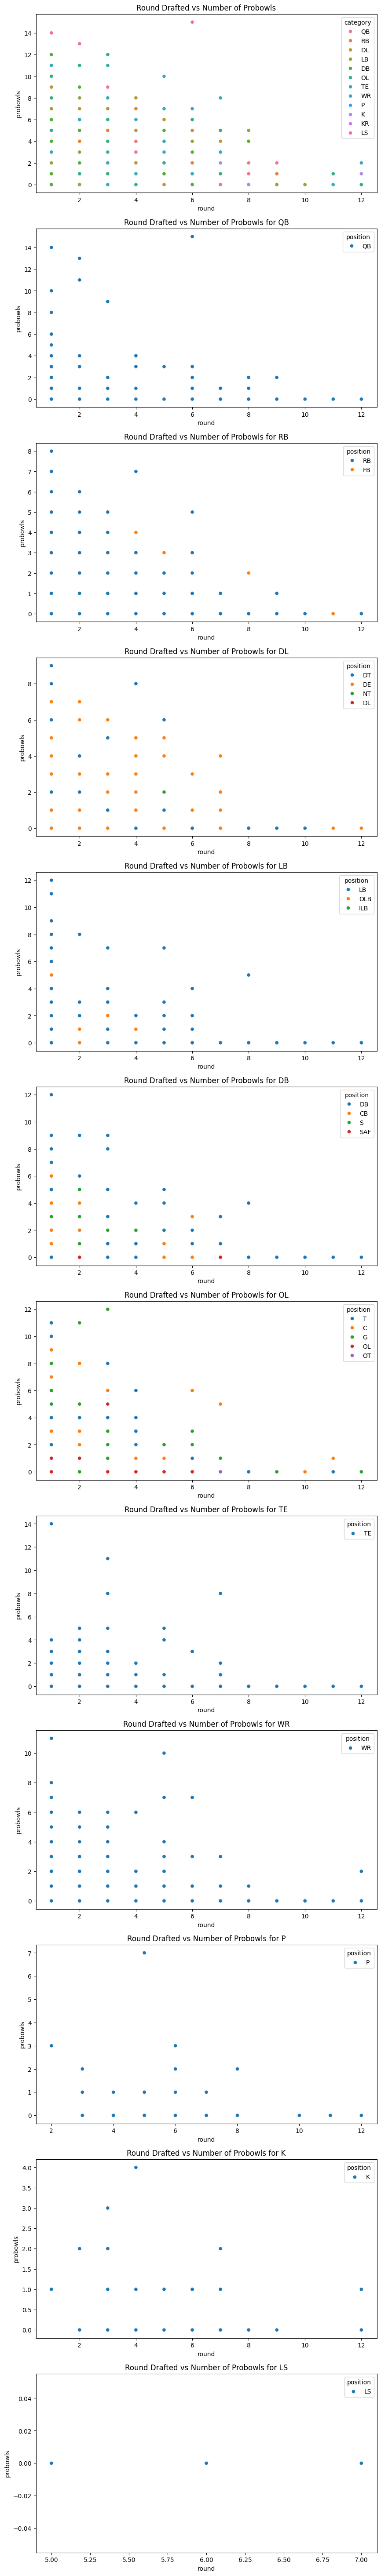

In [194]:
fig, ax = plt.subplots(12, 1, figsize=(10, 75))

sns.scatterplot(data=data, x='round', y='probowls', ax=ax[0], hue='category')
ax[0].set_title('Round Drafted vs Number of Probowls')

sns.scatterplot(data=QB, x='round', y='probowls', ax=ax[1], hue='position')
ax[1].set_title('Round Drafted vs Number of Probowls for QB')

sns.scatterplot(data=RB, x='round', y='probowls', ax=ax[2], hue='position')
ax[2].set_title('Round Drafted vs Number of Probowls for RB')

sns.scatterplot(data=DL, x='round', y='probowls', ax=ax[3], hue='position')
ax[3].set_title('Round Drafted vs Number of Probowls for DL')

sns.scatterplot(data=LB, x='round', y='probowls', ax=ax[4], hue='position')
ax[4].set_title('Round Drafted vs Number of Probowls for LB')

sns.scatterplot(data=DB, x='round', y='probowls', ax=ax[5], hue='position')
ax[5].set_title('Round Drafted vs Number of Probowls for DB')

sns.scatterplot(data=OL, x='round', y='probowls', ax=ax[6], hue='position')
ax[6].set_title('Round Drafted vs Number of Probowls for OL')

sns.scatterplot(data=TE, x='round', y='probowls', ax=ax[7], hue='position')
ax[7].set_title('Round Drafted vs Number of Probowls for TE')

sns.scatterplot(data=WR, x='round', y='probowls', ax=ax[8], hue='position')
ax[8].set_title('Round Drafted vs Number of Probowls for WR')

sns.scatterplot(data=P, x='round', y='probowls', ax=ax[9], hue='position')
ax[9].set_title('Round Drafted vs Number of Probowls for P')

sns.scatterplot(data=K, x='round', y='probowls', ax=ax[10], hue='position')
ax[10].set_title('Round Drafted vs Number of Probowls for K')

sns.scatterplot(data=LS, x='round', y='probowls', ax=ax[11], hue='position')
ax[11].set_title('Round Drafted vs Number of Probowls for LS')

# Step 3 continued

In [195]:
data

,season,round,pick,team,pfr_player_name,hof,position,category,side,college,...,pass_ints,rush_atts,rush_yards,rush_tds,receptions,rec_yards,rec_tds,def_solo_tackles,def_ints,def_sacks
0,1990,1,1,IND,Jeff George,False,QB,QB,O,Illinois,...,113.0,168.0,307.0,2.0,0.0,0.0,0.0,NaN,NaN,NaN
1,1990,1,2,NYJ,Blair Thomas,False,RB,RB,O,Penn St.,...,0.0,533.0,2236.0,7.0,71.0,513.0,2.0,NaN,NaN,NaN
2,1990,1,3,SEA,Cortez Kennedy,True,DT,DL,D,Miami (FL),...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,58.0
3,1990,1,4,TAM,Keith McCants,False,DE,DL,D,Alabama,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,13.5
4,1990,1,5,SDG,Junior Seau,True,LB,LB,D,USC,...,0.0,0.0,0.0,0.0,2.0,8.0,0.0,NaN,18.0,56.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8550,2022,7,258,GNB,Samori Toure,False,WR,WR,O,Nebraska,...,0.0,0.0,0.0,0.0,5.0,82.0,1.0,NaN,NaN,NaN
8551,2022,7,259,KAN,Nazeeh Johnson,False,SAF,DB,D,Marshall,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,NaN,NaN
8552,2022,7,260,LAC,Zander Horvath,False,RB,RB,O,Purdue,...,0.0,4.0,8.0,0.0,5.0,8.0,2.0,1.0,NaN,NaN
8553,2022,7,261,LAR,AJ Arcuri,False,OT,OL,O,Michigan St.,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


Text(0.5, 1.0, 'Games Played VS Number Of Sacks For Defensive Linemen')

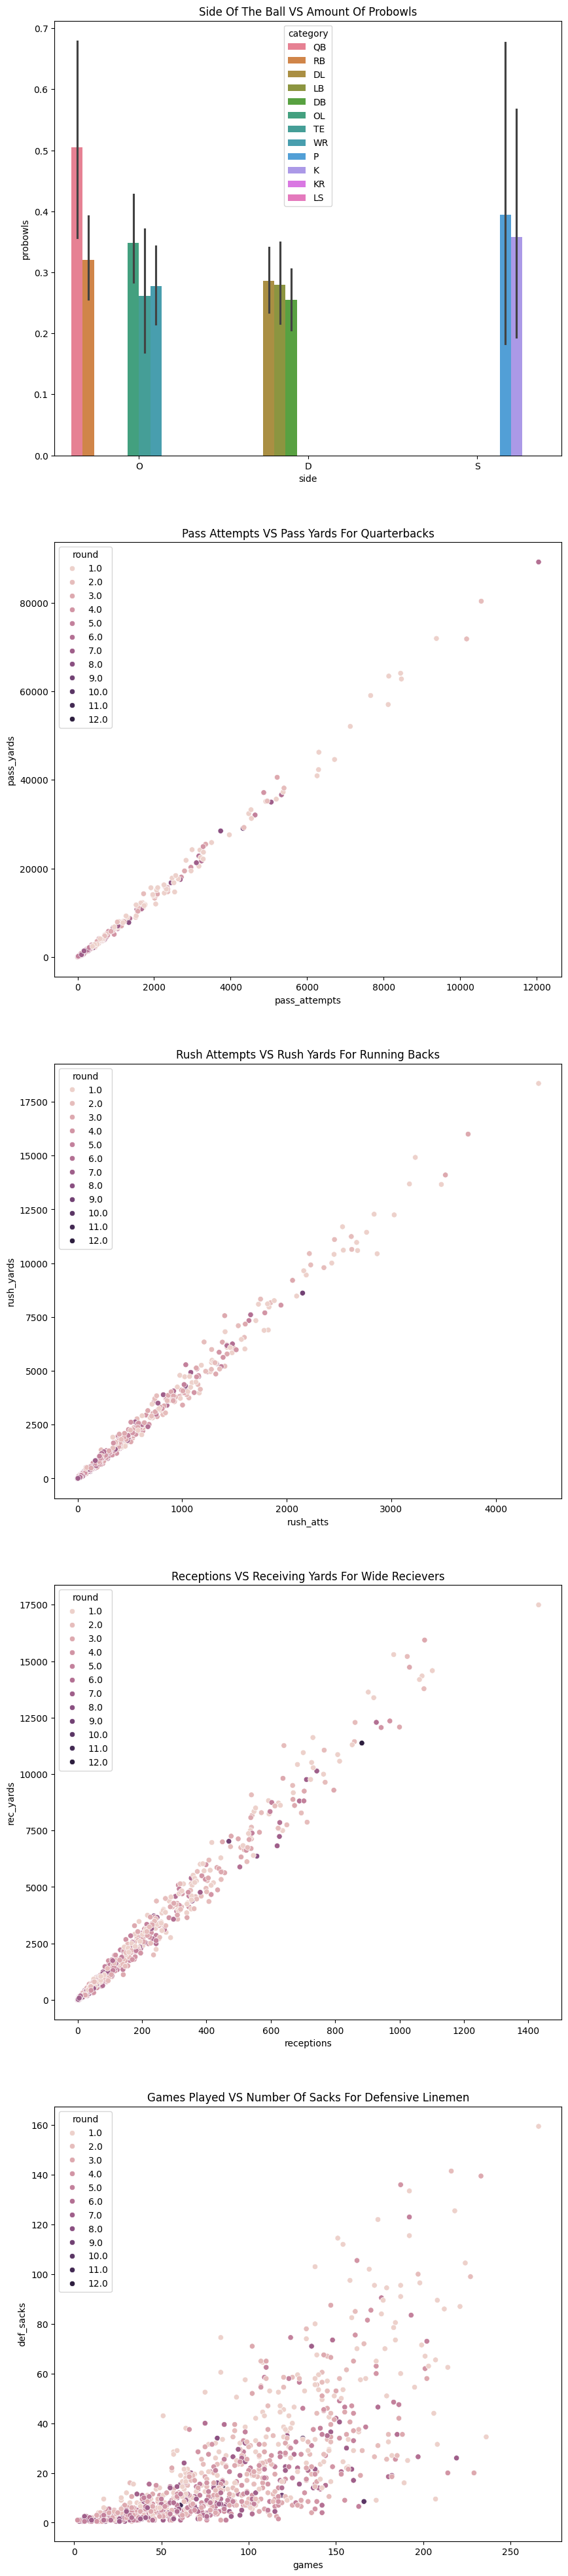

In [196]:
fig, ax = plt.subplots(5, 1, figsize=(10, 50))

sns.barplot(data=data, x='side', y='probowls', hue='category', ax=ax[0])
ax[0].set_title('Side Of The Ball VS Amount Of Probowls')

sns.scatterplot(data=QB, x='pass_attempts', y='pass_yards', hue='round', ax=ax[1], legend='full')
ax[1].set_title('Pass Attempts VS Pass Yards For Quarterbacks')

sns.scatterplot(data=RB, x='rush_atts', y='rush_yards', hue='round', ax=ax[2], legend='full')
ax[2].set_title('Rush Attempts VS Rush Yards For Running Backs')

sns.scatterplot(data=WR, x='receptions', y='rec_yards', hue='round', ax=ax[3], legend='full')
ax[3].set_title('Receptions VS Receiving Yards For Wide Recievers')

sns.scatterplot(data=DL, x='games', y='def_sacks', hue='round', ax=ax[4], legend='full')
ax[4].set_title('Games Played VS Number Of Sacks For Defensive Linemen')

# Step 4 Linear Regression
- The question I am going to try and answer is if I can tell what round a quarterback was drafted in based off of their career passing attempts and passing yards.

In [197]:
QB.dropna(subset=['pass_attempts'], inplace=True)
QB

,season,round,pick,team,pfr_player_name,hof,position,category,side,college,...,pass_attempts,pass_yards,pass_tds,pass_ints,rush_atts,rush_yards,rush_tds,receptions,rec_yards,rec_tds
0,1990.0,1.0,1.0,IND,Jeff George,False,QB,QB,O,Illinois,...,3967.0,27602.0,154.0,113.0,168.0,307.0,2.0,0.0,0.0,0.0
6,1990.0,1.0,7.0,DET,Andre Ware,False,QB,QB,O,Houston,...,161.0,1112.0,5.0,8.0,38.0,217.0,0.0,0.0,0.0,0.0
58,1990.0,3.0,59.0,NWE,Tom Hodson,False,QB,QB,O,LSU,...,320.0,1823.0,7.0,11.0,21.0,90.0,0.0,1.0,-6.0,0.0
62,1990.0,3.0,63.0,CHI,Peter Tom Willis,False,QB,QB,O,Florida St.,...,183.0,1261.0,6.0,15.0,5.0,14.0,0.0,0.0,0.0,0.0
69,1990.0,3.0,70.0,PIT,Neil O'Donnell,False,QB,QB,O,Maryland,...,3229.0,21690.0,120.0,68.0,215.0,446.0,4.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8378,2022.0,3.0,86.0,TEN,Malik Willis,False,QB,QB,O,Liberty,...,61.0,276.0,0.0,3.0,27.0,123.0,1.0,0.0,0.0,0.0
8429,2022.0,4.0,137.0,NWE,Bailey Zappe,False,QB,QB,O,Western Kentucky,...,92.0,781.0,5.0,3.0,10.0,0.0,0.0,1.0,-6.0,0.0
8436,2022.0,5.0,144.0,WAS,Sam Howell,False,QB,QB,O,North Carolina,...,19.0,169.0,1.0,1.0,5.0,35.0,1.0,0.0,0.0,0.0
8539,2022.0,7.0,247.0,MIA,Skylar Thompson,False,QB,QB,O,Kansas St.,...,105.0,534.0,1.0,3.0,14.0,21.0,0.0,0.0,0.0,0.0


In [198]:
QB.isna().sum()

season              0
round               0
pick                0
team                0
pfr_player_name     0
hof                 0
position            0
category            0
side                0
college             0
age                 0
to                  0
allpro              0
probowls            0
seasons_started     0
w_av                0
games               0
pass_completions    0
pass_attempts       0
pass_yards          0
pass_tds            0
pass_ints           0
rush_atts           0
rush_yards          0
rush_tds            0
receptions          0
rec_yards           0
rec_tds             0
dtype: int64

pass attempts average: 
0       2670.623418
6      -1135.376582
58      -976.376582
62     -1113.376582
69      1932.623418
           ...     
8378   -1235.376582
8429   -1204.376582
8436   -1277.376582
8539   -1191.376582
8554   -1126.376582
Name: pass_attempts, Length: 316, dtype: float64, pass yards average: 
0       18573.446203
6       -7916.553797
58      -7205.553797
62      -7767.553797
69      12661.446203
            ...     
8378    -8752.553797
8429    -8247.553797
8436    -8859.553797
8539    -8494.553797
8554    -7654.553797
Name: pass_yards, Length: 316, dtype: float64
the dot product of attempts and yards: 4574355861.54905


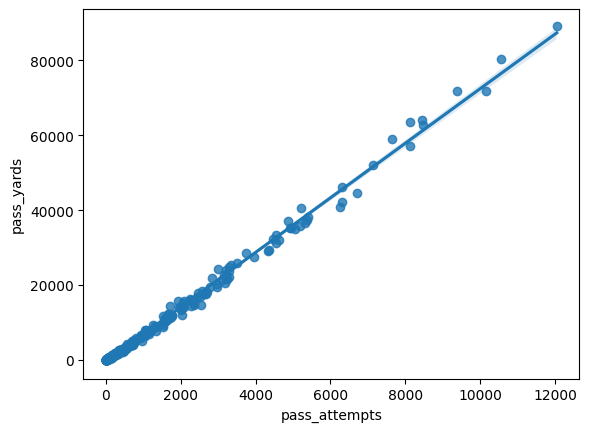

In [199]:
sns.regplot(data=QB, x='pass_attempts', y='pass_yards')

pass_attempts = QB['pass_attempts']
pass_yards = QB['pass_yards']

pass_attempts_bar = pass_attempts - pass_attempts.mean()
pass_yards_bar = pass_yards - pass_yards.mean()
print(f"pass attempts average: \n{pass_attempts_bar}, pass yards average: \n{pass_yards_bar}")

Attempts_dot_Yards = pass_attempts_bar.dot(pass_yards_bar)
print(f"the dot product of attempts and yards: {Attempts_dot_Yards/2}")

In [200]:
print(f"the correlation of a and b: \n{np.corrcoef(pass_attempts_bar, pass_yards_bar)}")

print(f"Cov: {np.cov(QB['pass_attempts'], QB['pass_yards'])}")

print(f"Coef: {np.corrcoef(QB['pass_attempts'], QB['pass_yards'])}")

the correlation of a and b: 
[[1.         0.99777516]
 [0.99777516 1.        ]]
Cov: [[3.98719586e+06 2.90435293e+07]
 [2.90435293e+07 2.12503377e+08]]
Coef: [[1.         0.99777516]
 [0.99777516 1.        ]]


In [201]:
b1 = QB['pass_attempts'].dot(QB['pass_yards']) / QB['pass_attempts'].dot(QB['pass_attempts'])
b0 = QB['pass_yards'].mean() - b1 * QB['pass_attempts'].mean()

print(f"y = b0: {b0:0.3f} + b1: {b1:0.3f}x")

y = b0: -291.328 + b1: 7.189x


In [202]:
X = np.array(QB['pass_attempts']).reshape(-1, 1)
Y = np.array(QB['pass_yards']).reshape(-1, 1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

regressor = LinearRegression()
regressor.fit(X_train, Y_train)
Y_pred_test = regressor.predict(X_test)
Y_pred_train = regressor.predict(X_train)

X_trainDF = pd.DataFrame(X_train, columns=['pass_attempts'])
Y_trainDF = pd.DataFrame(Y_train, columns=['pass_yards'])
X_testDF = pd.DataFrame(X_test, columns=['pass_attempts'])
Y_testDF = pd.DataFrame(Y_test, columns=['pass_yards'])

display(X_trainDF)
display(Y_trainDF)
display(X_testDF)
display(Y_testDF)

,pass_attempts
0,20.0
1,946.0
2,119.0
3,6717.0
4,48.0
...,...
247,349.0
248,119.0
249,19.0
250,3106.0


,pass_yards
0,125.0
1,6351.0
2,638.0
3,44611.0
4,402.0
...,...
247,2215.0
248,566.0
249,88.0
250,21291.0


,pass_attempts
0,408.0
1,933.0
2,318.0
3,11.0
4,307.0
...,...
59,4350.0
60,3217.0
61,345.0
62,1268.0


,pass_yards
0,2082.0
1,6632.0
2,1826.0
3,96.0
4,2145.0
...,...
59,29253.0
60,22464.0
61,1835.0
62,9271.0


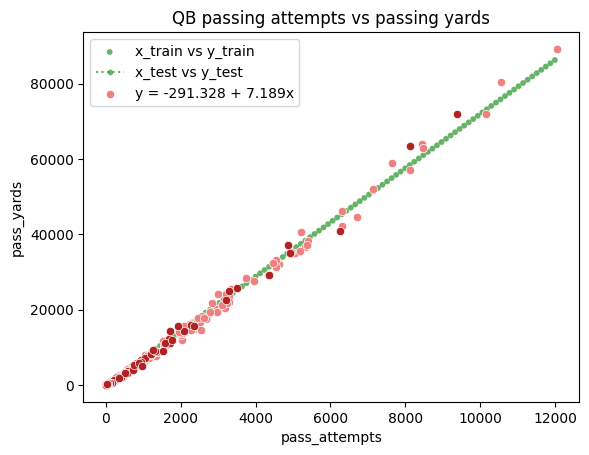

In [203]:
X_line = np.linspace(0,12000,100)
Y_line = b0 = b1 * X_line

# sns.scatterplot(data=QB, x=QB['pass_attempts'], y=QB['pass_yards'], color='red')
sns.scatterplot(x=X_line, y=Y_line, color='green', linestyle=':', size=1, alpha=0.6).set(title='QB passing attempts vs passing yards')
sns.scatterplot(data=pd.concat([X_trainDF, Y_trainDF], axis=1), x='pass_attempts', y='pass_yards', color='lightcoral', label='x_train vs y_train')
sns.scatterplot(data=pd.concat([X_testDF, Y_testDF], axis=1), x='pass_attempts', y='pass_yards', color='firebrick', label='x_test vs y_test')
plt.legend(['x_train vs y_train', 'x_test vs y_test', 'y = -291.328 + 7.189x'])

# Analysis of Data
- Will go through all of the MAE, SSE, MSE, RMSE, RMSLE

In [204]:
display(mae(Y_pred_test, Y_pred_train))
display(mse(Y_pred_test, Y_pred_train))
display(sse(Y_pred_test, Y_pred_train))
display(rmse(Y_pred_test, Y_pred_train))

array([13590.89436866])

array([4.40304376e+08])

array([2.817948e+10])

array([20983.43097575])

# Interactive Graph

In [205]:
import plotly.express as px

px.scatter(QB, x='pass_attempts', y='pass_yards', color='round', size='pick')